# EX3

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
from scipy.optimize import minimize
from statistics import mean

input_layer_size = 400 # 20x20 Input Images of Digits
num_labels = 10 # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

## Visualize data

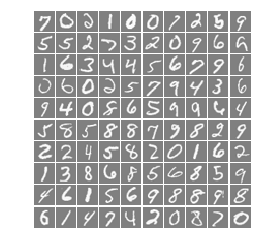

In [14]:
def display_data(x, example_width=None):
    x_size = x.shape
    if example_width is None:
        example_width = int(round(math.sqrt(x_size[1])))
    
    # Compute rows and columns
    example_height = int(x_size[1] / example_width)
    
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(x_size[0]))
    display_cols = math.ceil(x_size[0] / display_rows)
        
    # Betwen image pading
    pad = 1
    
    # Ensure we treat as int values
    display_arr = np.ones((pad + display_rows * (example_height + pad),
                           pad + display_cols * (example_width + pad) ))
        
    curr_ex = 0
    i = 0
    j = 0
    while j < display_rows:
        while i < display_cols:
            if curr_ex > x_size[0]:
                break 
            # Copy the patch
            # Get max value of the patch
            max_val = max(abs(x[curr_ex, :]))
            
            j_idx = pad + (j - 1) * (example_height + pad)
            i_idx = pad + (i - 1) * (example_width + pad)
            
            tmp = np.reshape(x[curr_ex,:], (example_height, example_width)) / max_val
            
            display_arr[j_idx + np.r_[range(0, example_height)],
                        i_idx + np.c_[range(0, example_width)]] = tmp
                        
            curr_ex += 1
            i += 1
        j += 1
        i = 0
        if curr_ex > x_size[0]:
            break
    plt.set_cmap('gray') # Use grey colour         
    img = plt.imshow(display_arr, vmin=-1, vmax=1)
    plt.axis('off')

mat = scipy.io.loadmat('machine-learning-ex3/ex3/ex3data1.mat') # training data
orig_X = mat['X']
orig_Y = mat['y']

random_indices = np.random.randint(0, orig_X.shape[0], size=100)
selection = orig_X[random_indices]

display_data(selection)

## Vectorized logisitic regression

In [3]:
print('Testing lrCostFunction() with regularization')

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_function_reg(theta, x, y, lambda_param=1, alpha=1):
    m = y.size
    h = sigmoid(x@theta.reshape(-1,1))
    t = np.r_[[[0]],theta[1:].reshape(-1,1)]
    grad = (alpha / m) * x.T@(h-y) + (lambda_param / m * t)
    return grad.flatten()

def cost_function_reg(theta, x, y, lambda_t):
    m = y.size
    h = sigmoid(x@theta)
    t = theta[1:]
    return 1.0 / m * (-y.T@np.log(h) - (1 - y).T@np.log(1 - h)) + (lambda_t / (2 * m) * np.sum(np.power(t, 2)))

theta_t = np.array([[-2], [-1], [1], [2]])
a = np.ones([5,1])
b = np.reshape(range(1, 16), (5,3), order='F') / 10
x_t = np.concatenate([a, b], axis=1)
y_t = (np.array([[1], [0], [1], [0], [1]]) >= 0.5).astype(int)
lambda_t = 3

cost = cost_function_reg(theta_t, x_t, y_t, lambda_t)
grad = gradient_function_reg(theta_t, x_t, y_t, lambda_t)

print('Cost: {}'.format(cost))
print('Expected cost: 2.534819')
print('Gradients:')
print('{}'.format(grad))
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')

Testing lrCostFunction() with regularization
Cost: [[2.5348194]]
Expected cost: 2.534819
Gradients:
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


## One vs all

In [17]:
def one_vs_all(x, y, num_labels, lambda_p):
    m = x.shape[0]
    n = x.shape[1]
    # Add intercept term
    x = np.append(np.ones((m, 1)), x, axis=1)
    # Init all theta's
    all_theta = np.zeros((num_labels, n+1))
    for idx in range(1, num_labels + 1):
        initial_theta = np.zeros((n+1, 1))
        xopt = minimize(cost_function_reg, initial_theta, args=(x, (y == idx).astype(int), lambda_p), 
                method='CG', jac=gradient_function_reg, options={'maxiter':50})
        all_theta[idx-1] = xopt.x
    return all_theta

lambda_p = 0.1
thetas = one_vs_all(orig_X, orig_Y, num_labels, lambda_p)

## Predict

In [20]:
def predict_one_vs_all(all_theta, x):
    m = x.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros((m, 1))
    # Add intercept term
    x = np.append(np.ones((m, 1)), x, axis=1)
    return np.argmax(sigmoid(x@all_theta.T), axis=1) + 1

pred = predict_one_vs_all(thetas, orig_X)
acc = np.mean(pred == orig_Y.ravel())*100
print('Training Set Accuracy: {}'.format(acc))

Training Set Accuracy: 95.08


# Part 2

## Load weights & predict

In [41]:
def predict(theta1, theta2, x):
    m = x.shape[0]
    num_labels = theta2.shape[0]
    p = np.zeros((m, 1))
    # Add intercept term
    x = np.append(np.ones((m, 1)), x, axis=1)
    
    # Do sigmoid of dot prod betweeb input & theta 1
    t = sigmoid(x@theta1.T)
    # Add hidden layer back in
    t = np.append(np.ones((t.shape[0], 1)), t, axis=1)
    # Do sigmoid of dot prod betweeb theta 1 & theta 2
    t2 = sigmoid(t@theta2.T)
    # Return output h
    return np.argmax(t2, axis=1) + 1

print('Loading Saved Neural Network Parameters ...')
# Load the weights into variables Theta1 and Theta2
weights = scipy.io.loadmat('machine-learning-ex3/ex3/ex3weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

# Do prediction
pred = predict(theta1, theta2, orig_X)
acc = np.mean(pred == orig_Y.ravel())*100
print('Training Set Accuracy: {}'.format(acc))

Loading Saved Neural Network Parameters ...
Training Set Accuracy: 97.52
